In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [5]:
import pandas as pd

# Read the dataset
dataset = pd.read_json("data_without_hashtags.json")

# Assuming "is_sarcastic" is the column you're interested in
sarcastic_counts = dataset['isSarcastic'].value_counts()

# Display the result
print("Number of rows for each value in the 'isSarcastic' column:")
print(sarcastic_counts)

Number of rows for each value in the 'isSarcastic' column:
isSarcastic
0    21292
1    18488
Name: count, dtype: int64


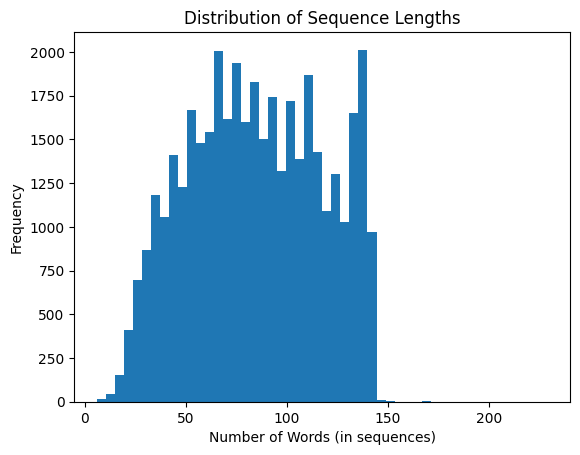

In [6]:
import matplotlib.pyplot as plt

text_data = dataset['text']

# Calculate sentence lengths
sentence_lengths = [len(sequence) for sequence in text_data]

# Plot histogram
plt.hist(sentence_lengths, bins=50)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Number of Words (in sequences)')
plt.ylabel('Frequency')
plt.show()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
##from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Read the dataset
#dataset = pd.read_json("data_without_hashtags.json")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['isSarcastic'], test_size=0.2, random_state=42)

# Tokenize and vectorize the training text data using Tokenizer and pad_sequences
max_length = 138
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_length)

y_train_categorical = to_categorical(y_train, num_classes=2)

# Display the shapes of the resulting matrices
print("Shape of X_train:", X_train.shape)

# Tokenize and vectorize the testing text data using the same Tokenizer
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_length)

# Display the shape of X_test
print("Shape of X_test:", X_test.shape)

Shape of X_train: (31824, 138)
Shape of X_test: (7956, 138)


In [8]:
from keras.layers import CuDNNLSTM
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_dim = 100

# Define the vocabulary size based on the actual number of unique words in the training data
vocab_size = len(tokenizer.word_index) + 1

max_length = 138

m1 = Sequential()
m1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
m1.add(CuDNNLSTM(units=150))  # Use CuDNNLSTM instead of LSTM
m1.add(Dense(units=1, activation='sigmoid'))

m1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
m1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 138, 100)          3221100   
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 150)               151200    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 3,372,451
Trainable params: 3,372,451
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train the model
m1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = m1.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy * 100:.2f}%')

Epoch 1/10
498/498 [==============================] - 12s 18ms/step - loss: 0.5443 - accuracy: 0.7128 - val_loss: 0.4801 - val_accuracy: 0.7646
Epoch 2/10
498/498 [==============================] - 8s 17ms/step - loss: 0.3488 - accuracy: 0.8468 - val_loss: 0.4939 - val_accuracy: 0.7700
Epoch 3/10
498/498 [==============================] - 8s 17ms/step - loss: 0.2326 - accuracy: 0.9060 - val_loss: 0.5793 - val_accuracy: 0.7489
Epoch 4/10
498/498 [==============================] - 9s 17ms/step - loss: 0.1632 - accuracy: 0.9348 - val_loss: 0.7480 - val_accuracy: 0.7359
Epoch 5/10
498/498 [==============================] - 9s 17ms/step - loss: 0.1186 - accuracy: 0.9526 - val_loss: 0.7536 - val_accuracy: 0.7384
Epoch 6/10
498/498 [==============================] - 9s 17ms/step - loss: 0.0906 - accuracy: 0.9648 - val_loss: 0.9814 - val_accuracy: 0.7353
Epoch 7/10
498/498 [==============================] - 8s 17ms/step - loss: 0.0716 - accuracy: 0.9720 - val_loss: 1.0457 - val_accuracy: 0.727

In [10]:
from sklearn.metrics import precision_score, recall_score

# Predict on validation data
y_val_pred_prob_m1 = m1.predict(X_test)
y_val_pred_m1 = (y_val_pred_prob_m1 > 0.5).astype(int)  # Threshold for binary classification

# Assuming y_test is in binary format (0 or 1)
y_val_true_m1 = y_test

# Calculate precision and recall for binary classification
precision_m1 = precision_score(y_val_true_m1, y_val_pred_m1)
recall_m1 = recall_score(y_val_true_m1, y_val_pred_m1)

# print the results
print(f'Precision: {precision_m1:.4f}')
print(f'Recall: {recall_m1:.4f}')

249/249 [==============================] - 1s 5ms/step
Precision: 0.6835
Recall: 0.7677


In [11]:
#this had to be implemented this way because the pickle and joblib librays that where previously used use a unroll function in for dumping models however this is unsuported with the CuDNNLSTM version

import joblib

# Save the model architecture
with open('model_cudnn_lstm_architecture.joblib', 'wb') as f:
    joblib.dump(m1.to_json(), f)

# Save the model weights
m1.save_weights('model_cudnn_lstm_weights.h5')



In [12]:
from keras.models import model_from_json
import joblib

# Load the model architecture
with open('model_cudnn_lstm_architecture.joblib', 'rb') as f:
    model_json = joblib.load(f)

m1_loaded = model_from_json(model_json)

# Load the model weights
m1_loaded.load_weights('model_cudnn_lstm_weights.h5')


In [13]:
#run saved model for prediciton

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
max_length = 138

# Function to preprocess user input and make a prediction
def predict_sarcasm(user_input, model, tokenizer, max_length, threshold=0.5):
    # Tokenize and preprocess user input
    user_input_sequence = tokenizer.texts_to_sequences([user_input])
    user_input_padded = pad_sequences(user_input_sequence, maxlen=max_length)

    # Make prediction
    prediction_prob = model.predict(user_input_padded)
    predicted_label = 1 if prediction_prob[0, 0] > threshold else 0

    return predicted_label, prediction_prob

# Example usage:
user_input = input("Enter a sentence: ")

# Call the predict_sarcasm function with a custom threshold (e.g., 0.3)
predicted_label, predicted_prob = predict_sarcasm(user_input, m1_loaded, tokenizer, max_length, threshold=0.3)

# Display the prediction
if predicted_label == 1:
    print("The model predicts that the input is sarcastic.")
else:
    print("The model predicts that the input is not sarcastic.")

# Optional: Display the predicted probabilities
print("Predicted Probabilities:", predicted_prob)
print("User input", user_input)

1/1 [==============================] - 0s 134ms/step
The model predicts that the input is sarcastic.
Predicted Probabilities: [[0.58644634]]
User input not sarcastic here
